# ADL Final Project

Mike Wang (yw3423)

Wangzhi Li (wl2737)

## Starter Code

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support, accuracy_score, f1_score, auc

### Starter Code Function

In [3]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [4]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))


## Window Slicing

### Function to do window slicing

In [ ]:
#return tissue percentage of the patch of slide
def tissue_percentage(image):
  tissue_pixels = find_tissue_pixels(image)
  percent_tissue = len(tissue_pixels) / float(image.shape[0] * image.shape[1])
  return percent_tissue



#return patches from window slicing at the anchor_level, and their corresponding outcomes, the zoom out patches at larger levels, 
#only keeping the patches with tissue percentage greater than threshold.
PATCHSIZE  =  229

def window_patch_rmgrey(slide, mask, levels, anchor_level, threshold = 0.01):
  #get the dimension for slide at level 0
  nrow = slide.level_dimensions[0][0]
  ncol = slide.level_dimensions[0][1]
  slide_patches =[]
  xy_ind = []
  keep_ind = []
  outcomes = []
  level_patches = []
  half_size = int(PATCHSIZE/2)
  for k in range(len(levels)):
    level_patch = []
    level_patches.append(level_patch)
  #factor = 2 ** level
  anchor_factor = 2 ** anchor_level #the level where we would have side by side patches
  x_0_1eft = 0 
  i = 0
  while (x_0_1eft + PATCHSIZE * anchor_factor<= nrow ):
    y_0_up = 0 
    while (y_0_up + PATCHSIZE *anchor_factor <= ncol):    
      patch = read_slide(slide, x = x_0_1eft , y = y_0_up, level = anchor_level, width=PATCHSIZE, height=PATCHSIZE)
      path_mask = read_slide(mask, x = x_0_1eft , y = y_0_up, level = anchor_level, width=PATCHSIZE, height=PATCHSIZE)[:,:,0]
      #get the center 128X128 mask region for outcome
      sp = half_size - 64
      ep = half_size + 64 
      center_mask = path_mask[sp:ep, sp:ep]
      outcome  = 0
      if (np.sum(center_mask) > 0):
        outcome = 1
      #only keep tissue pixel > threshold to set
      t_perc = tissue_percentage(patch)
      if ((t_perc > threshold) or (threshold == 0)):
        slide_patches.append(patch)
        for k in range(len(levels)):
          level = levels[k]
          x_level_kp = (x_0_1eft + half_size * anchor_factor - ((2 ** level) * half_size))
          y_level_kp = (y_0_up + half_size * anchor_factor - (( 2 ** level) * half_size)) 
          level_patch_kp = read_slide(slide, x = x_level_kp , y = y_level_kp, level = level, width=PATCHSIZE , height=PATCHSIZE )
          level_patches[k].append(level_patch_kp)
        outcomes.append(outcome)
        keep_ind.append(i)
      y_0_up = y_0_up + PATCHSIZE  * anchor_factor
      i = i +1
    x_0_1eft = x_0_1eft + PATCHSIZE  * anchor_factor
  return np.array(slide_patches), outcomes, keep_ind, level_patches

### Testing code for window_patch_rmgrey

In [ ]:
# Plotting grid for input patches at their original location in the slide, 
# black for the location with missing patches.
def plotwindow(patches, keep_ind, row, col):
  ratio = row/col
  fcol = 10
  frow = int(10 * ratio)
  fig, axes = plt.subplots(nrows=row,ncols=col, figsize=(fcol, frow)) 
  j = 0
  for i in range((row*col)):
      r = int(i % row)
      c = int(i / row)
      img = np.zeros((PATCHSIZE , PATCHSIZE ))
      if i in keep_ind:
        img = patches[j]
        j = j + 1
      axes[r][c].imshow(img)
      plt.figure();
# testing whether the outcomes are in right location     
def plottumor(outcomes, keep_ind, row, col):
  ratio = row/col
  fcol = 10
  frow = int(10 * ratio)
  fig, axes = plt.subplots(nrows=row,ncols=col, figsize=(fcol, frow)) 
  j = 0
  for i in range((row*col)):
    img = np.zeros((PATCHSIZE , PATCHSIZE ))
    if i in keep_ind : 
      outcome = outcomes[j]
      if (outcome == 1):
        img = np.ones((PATCHSIZE , PATCHSIZE ))
        img[0][0] = 0
      j = j+1
    r = int(i % row)
    c = int(i / row)
    axes[r][c].imshow(img);
    plt.figure();

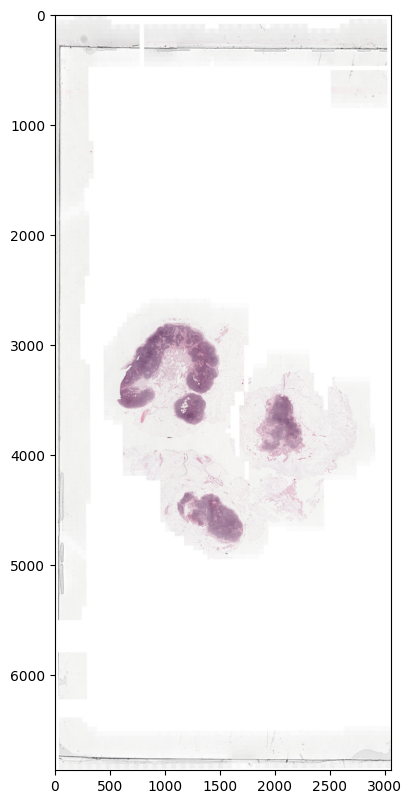

In [ ]:
slide = open_slide("tumor_002.tif")
mask = open_slide("tumor_002_mask.tif")
i = 5
slide_image= read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=i, 
                         width=slide.level_dimensions[i][0], 
                         height=slide.level_dimensions[i][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

In [ ]:
patches, outcomes, keep_ind, level_patches = window_patch_rmgrey(slide, mask, [], 5, threshold = 0.01)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


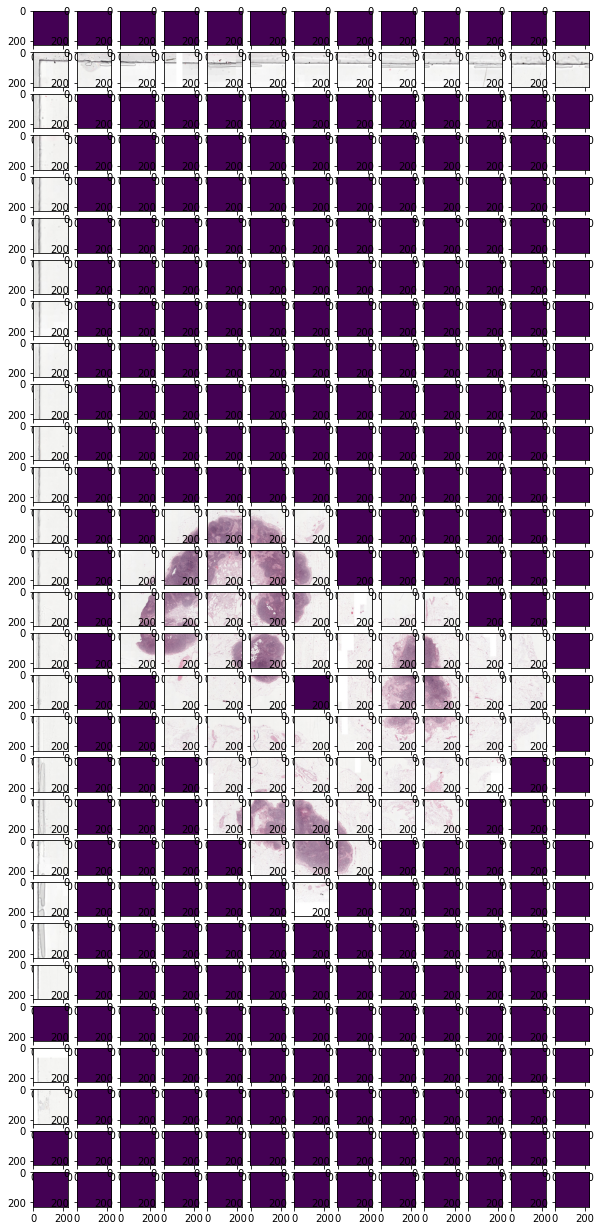

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
row = int(slide.level_dimensions[5][1]/PATCHSIZE)
col = int(slide.level_dimensions[5][0]/PATCHSIZE)
plotwindow(patches, keep_ind, row, col)

### Data - Use window_patch_rmgrey to Get Patches for All Tumor Slides in wsi-urls.txt

In [ ]:
#upload the wsi-urls.txt manually and read in to get all available tumor file name
filename = "wsi-urls.txt"
with open(filename) as f:
    content = f.readlines()
content = [x.strip() for x in content] 
#get slide and mask file name from txt
slides = []
masks = []
for x in content:
  if (x.endswith("mask.tif")):
    mask_filename = x[55:]
    masks.append(mask_filename)
  elif (x.endswith(".tif")):
    slide_filename = x[55:]
    slides.append(slide_filename)

#only keep the file has both slide and mask files
slides_kps = []
allmasks = " ".join(masks)
for slide in slides:
  if slide[:9] in allmasks:
    slides_kps.append(slide)
    
#check whether slides_kps and mask have the same order and for same tumor cell
for i in range(len(slides_kps)):
  if slides_kps[i][:9] != masks[i][:9] :
    print("unmatch at " , i)

In [ ]:
#output as pickle file
import pickle

def save_data(fp, data):
    with open(fp, "wb") as fo:
        pickle.dump(data, fo)

def load_data(fp):
    with open(fp, "rb") as fo:
        data = pickle.load(fo)
    return data

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#loop through all the slides and mask in txt file and download them to drive
n_pics = len(slides_kps)
for j in range(n_pics):
  slide_path = slides_kps[j]
  tumor_mask_path = masks[j]
  slide_url = 'https://storage.googleapis.com/applied-dl/tumor-slides/%s' % slide_path
  mask_url = 'https://storage.googleapis.com/applied-dl/tumor-slides/%s' % tumor_mask_path
  # Download the whole slide image
  if not os.path.exists(slide_path):
    !curl -O $slide_url
  # Download the tumor mask
  if not os.path.exists(tumor_mask_path):
    !curl -O $mask_url

In [ ]:
#Use window_patch_rmgrey to get patches for all the tumor slides avaliable
#and split them into training and testing.

#choose the anchor level to do window slicing
anc_level = 3
#zoom out levels
mult_level = [4,5]

#train test split ratio 80:20
n_pics = len(slides_kps)
train_len = int(round(n_pics * 0.8,0))
g_path = "/content/drive/My Drive/ADL_project/"

# initialize directory
pathes = [(g_path +"tumor/"), (g_path + "normal/")]
for path in pathes:
  if not os.path.isdir(path):
    os.mkdir(path)

#initialized all list
nc_train = []
tc_train = []
nc_mult_train = []
tc_mult_train = []
test_patches = []
test_outcomes = []
test_mult =[]

for k in range(len(mult_level)):
  nc_level_patch = []
  tc_level_patch = []
  nc_mult_train.append(nc_level_patch)
  tc_mult_train.append(tc_level_patch)


#loop through all the slides in txt file and do window patching
for j in range(n_pics):
  slide_path = slides_kps[j]
  tumor_mask_path = masks[j]
  slide = open_slide(slide_path)
  tumor_mask = open_slide(tumor_mask_path)
  # train set treatment
  if (j < train_len): 
    mult_level_name = "".join([str(m) for m in mult_level])
    keep_patches, keep_outcomes, keep_ind, mult_patches = window_patch_rmgrey(slide, tumor_mask, mult_level, anc_level)

    # Since limited ram and we want a balance data, we perform downsampling to get even classes for tumor cell pictures and normal cell  
    tumor_cells =[]
    normal_cells =[]
    keep_outcomes = np.array(keep_outcomes)
    boo1_ko = keep_outcomes == 0
    normal_cell_idx = np.where(boo1_ko)[0]
    n_tumor = np.sum(keep_outcomes)
    np.random.seed(123)
    normal_cell_kp = np.random.choice(normal_cell_idx, n_tumor, replace = False)
    for i in range(len(keep_outcomes)):
      if keep_outcomes[i] == 1 :
        tumor_cells.append(keep_patches[i])
        tc_train.append(keep_patches[i])
        for k in range(len(mult_level)):
          tc_mult_train[k].append(mult_patches[k][i])
      else:
        if (i in normal_cell_kp):
          normal_cells.append(keep_patches[i])
          nc_train.append(keep_patches[i])
          for k in range(len(mult_level)):
            nc_mult_train[k].append(mult_patches[k][i])
  else: 
    # test set threshold = 0 as no window should be through away
    keep_patches, keep_outcomes, keep_ind, mult_patches = window_patch_rmgrey(slide, tumor_mask, mult_level, anc_level, 0)
    test_patches.append(keep_patches)
    test_outcomes.append(keep_outcomes)
    test_mult.append(mult_patches)

#Save all train and test data
level_name = str(anc_level) + ".p"
nc_train_fp = pathes[1] +  "nc_train" + level_name
nc_mult_train_fp = pathes[1] +  "nc_mult_train" + level_name
tc_train_fp = pathes[0] +  "tc_train" + level_name
tc_mult_train_fp = pathes[0] +  "tc_mult_train" + level_name

test_patches_fp =  g_path + "test/test_patches"+ level_name
test_outcomes_fp = g_path + "test/test_outcomes"+ level_name
test_mult_fp = g_path + "test/test_mult"+ level_name


save_data(nc_train_fp, nc_train)
save_data(nc_mult_train_fp, nc_mult_train )
save_data(tc_train_fp, tc_train)
save_data(tc_mult_train_fp, tc_mult_train )
save_data(test_patches_fp, test_patches)
save_data(test_outcomes_fp, test_outcomes)
save_data(test_mult_fp, test_mult)

In [ ]:
#For load data (do this step if continuing training from previous)

g_path = "/content/drive/My Drive/ADL_project/"
pathes = [(g_path +"tumor/"), (g_path + "normal/")]
anc_level = 3
level_name = str(anc_level) + ".p"
nc_train_fp = pathes[1] +  "nc_train" + level_name
nc_mult_train_fp = pathes[1] +  "nc_mult_train" + level_name
tc_train_fp = pathes[0] +  "tc_train" + level_name
tc_mult_train_fp = pathes[0] +  "tc_mult_train" + level_name
test_patches_fp =  g_path + "test/test_patches"+ level_name
test_outcomes_fp = g_path + "test/test_outcomes"+ level_name
test_mult_fp = g_path + "test/test_mult"+ level_name

nc_train = load_data(nc_train_fp) #list
nc_mult_train = load_data(nc_mult_train_fp) #list
tc_train = load_data(tc_train_fp) #list
tc_mult_train = load_data(tc_mult_train_fp) #list
test_patches = load_data(test_patches_fp) #list
test_outcomes = load_data(test_outcomes_fp) #list
test_mult = load_data(test_mult_fp) #list

### transfer list to nparray (all level)

In [ ]:
#combine the train tumor cell patches and train normal cell patches into a train x array
def combine_train(tc, nc):
  train_x = tc + nc
  train_x = np.array(train_x)
  print(train_x.shape)
  return train_x 

train_x_lv3 = combine_train(tc_train, nc_train)
train_x_lv4 = combine_train(tc_mult_train[0],nc_mult_train[0])
train_x_lv5 = combine_train(tc_mult_train[1], nc_mult_train[1])

(1538, 229, 229, 3)
(1538, 229, 229, 3)
(1538, 229, 229, 3)


In [ ]:
#create label array for train set (label are the same for all levels)
n = len(tc_train)
tc_y = np.ones(n, dtype=int)
nc_y = np.zeros(n, dtype=int)

train_y = np.concatenate((tc_y , nc_y))
train_y.shape

(1538,)

## Model - One Level

### Training Model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
# Function help to build a neural network model using transfer learning from Inception V3 with default epochs = 20, and fune tuning after layers 251
# Also peform horizontal augmentation
def model_training(train_x, val_x, train_y, val_y, epochs = 20, fine_tune_at = 251):
  train_dataset = tf.data.Dataset.from_tensor_slices((train_x/255.0, train_y))
  val_dataset = tf.data.Dataset.from_tensor_slices((val_x/255.0, val_y))
  BATCH_SIZE = 16
  SHUFFLE_BUFFER_SIZE = 100
  
  # Shuffle and batch the datasets
  train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
  val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
  
  #Configure the dataset for performance
  AUTOTUNE = tf.data.experimental.AUTOTUNE
  train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
  val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
  
  #create model
  IMG_SHAPE = (229, 229, 3)
  base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
  base_model.trainable = False
  image_batch, label_batch = next(iter(train_dataset))
  feature_batch = base_model(image_batch)

  #transfer learning with fine-tuning (start directly with fine-tuning epoch)
  base_model.trainable = True
  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
  
  #add top layer
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  feature_batch_average = global_average_layer(feature_batch)
  prediction_layer = tf.keras.layers.Dense(1)
  prediction_batch = prediction_layer(feature_batch_average)

  #data augmentation
  data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal')])

  #define model
  inputs = tf.keras.Input(shape=(229, 229, 3))
  x = data_augmentation(inputs)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)

  #compile the model
  base_learning_rate = 0.0001
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  #fit the model
  history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset)
  return model, history

### Train Validation Split

In [ ]:
#balance spliting the train and validation set (idea method)
size = len(train_y)
train_size = int(0.8*size)
np.random.seed(111)
train_idx = np.random.choice(range(size), train_size, replace = False)
val_idx = np.delete(range(size), train_idx)


In [ ]:
#split by batches, not balanced but actually gives us better test result at the end
train_index = tf.data.Dataset.from_tensor_slices((np.array(range(len(train_x_lv3))), train_y))

BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE = 100

# Shuffle and batch the datasets and split val from train
tf.random.set_seed(111)
train_index = train_index.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
train_idx_batches = tf.data.experimental.cardinality(train_index)
val_idx = train_index.take(train_idx_batches // 5)
train_index = train_index.skip(train_idx_batches // 5)
size = len(train_y)
all_train =[]
for element in train_index:
  all_train = np.concatenate( (all_train, np.array(element[0])))
train_idx = all_train.astype(int)
val_idx = np.delete(range(size), train_idx)

In [ ]:
save_data("/content/drive/My Drive/ADL_project/train_idx.p", train_idx )
save_data("/content/drive/My Drive/ADL_project/val_idx.p", val_idx )

### Level 3 Model

In [ ]:
model_lv3, history_lv3 = model_training(train_x_lv3[train_idx], train_x_lv3[val_idx], train_y[train_idx], train_y[val_idx])

87916544/87910968 [==============================] - 0s 0us/step
Epoch 1/20
78/78 [==============================] - 117s 1s/step - loss: 0.6968 - accuracy: 0.6654 - val_loss: 4.5530 - val_accuracy: 0.0000e+00
Epoch 2/20
78/78 [==============================] - 107s 1s/step - loss: 1.1914 - accuracy: 0.5487 - val_loss: 2.7154 - val_accuracy: 0.0395
Epoch 3/20
78/78 [==============================] - 106s 1s/step - loss: 0.6915 - accuracy: 0.6285 - val_loss: 2.1925 - val_accuracy: 0.0789
Epoch 4/20
78/78 [==============================] - 106s 1s/step - loss: 0.4950 - accuracy: 0.7151 - val_loss: 2.2382 - val_accuracy: 0.0921
Epoch 5/20
78/78 [==============================] - 109s 1s/step - loss: 0.4626 - accuracy: 0.7560 - val_loss: 2.2472 - val_accuracy: 0.0987
Epoch 6/20
78/78 [==============================] - 109s 1s/step - loss: 0.4367 - accuracy: 0.7450 - val_loss: 2.2290 - val_accuracy: 0.1349
Epoch 7/20
78/78 [==============================] - 107s 1s/step - loss: 0.3767 - acc

In [ ]:
model_lv3.save("/content/drive/My Drive/ADL_project/submodel_lv3.h5")

In [ ]:
#function return the image of the cells and the mask of tumor cell predicted and true locations
#anc_level: the level where the patches was slicing from
#plot_level: the level where we want to plot
def get_mask(anc_level, plot_level, slide_path, predictions, outcomes):
  slide = open_slide(slide_path)
  width = slide.level_dimensions[anc_level][0]
  height = slide.level_dimensions[anc_level][1]
  plt_width = slide.level_dimensions[plot_level][0]
  plt_height = slide.level_dimensions[plot_level][1]
  mask_image = np.zeros((plt_height, plt_width))
  mask_image_true = np.zeros((plt_height, plt_width))
  row = int(height/PATCHSIZE)
  col = int(width/PATCHSIZE)
  step = int(PATCHSIZE/ (2**(plot_level - anc_level)))
  slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=plot_level, 
                         width=slide.level_dimensions[plot_level][0], 
                         height=slide.level_dimensions[plot_level][1])
  for i in range(len(predictions)):
    p = predictions[i]
    t = outcomes[i]
    r = int(i % row) * step
    c = int(i / row) * step
    if (p == 1):
      mask_image[r:(r+step),c:(c+step)] = np.ones((step,step))
    if (t == 1):
      mask_image_true[r:(r+step),c:(c+step)] = np.ones((step,step))

  return(slide_image, mask_image, mask_image_true)
  


In [ ]:
# plot the result heatmap on the tested cell image, prediction on the left, actual on the right
# Also return the overall true outcomes and predictions for all the test cells, plus the overall test f1 score.
def plot_test(model, plot_level, anc_level, test_outcomes):
  all_predictions =[]
  all_outcomes = []

  n_pics = len(slides_kps)
  train_len = int(round(n_pics * 0.8,0))
  test_size = n_pics - train_len

  fig, axes = plt.subplots(nrows = test_size, ncols=2, figsize=(20, test_size*10))
  for i in range(test_size):
    slide_path = slides_kps[train_len+i]
    predictions = model.predict(test_patches[i]/255.0).flatten()
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)
    all_predictions = np.concatenate((all_predictions, predictions))
    all_outcomes = np.concatenate((all_outcomes, test_outcomes[i]))
    f1 = f1_score(test_outcomes[i], predictions)
    #print(slide_path, '{:0.4f}'.format(roc))
    slide_image, mask_image, mask_image_true = get_mask(anc_level, plot_level, slide_path , predictions, test_outcomes[i])
    axes[i][0].imshow(slide_image)
    axes[i][0].imshow(mask_image, cmap='jet', alpha=0.5)
    axes[i][0].set_title("Predicted on Tumor Cell Location for " + slide_path+ " with F1 = {:0.4f}".format(f1))
    axes[i][1].imshow(slide_image)
    axes[i][1].imshow(mask_image_true, cmap='jet', alpha=0.5)
    axes[i][1].set_title("Actual Tumor Cell Location " + slide_path);

  all_f1= f1_score(all_outcomes, all_predictions)
  print("Overall f1: ", '{:0.4f}'.format(all_f1))
  return (all_outcomes, all_predictions, all_f1)

Overall f1:  0.7458


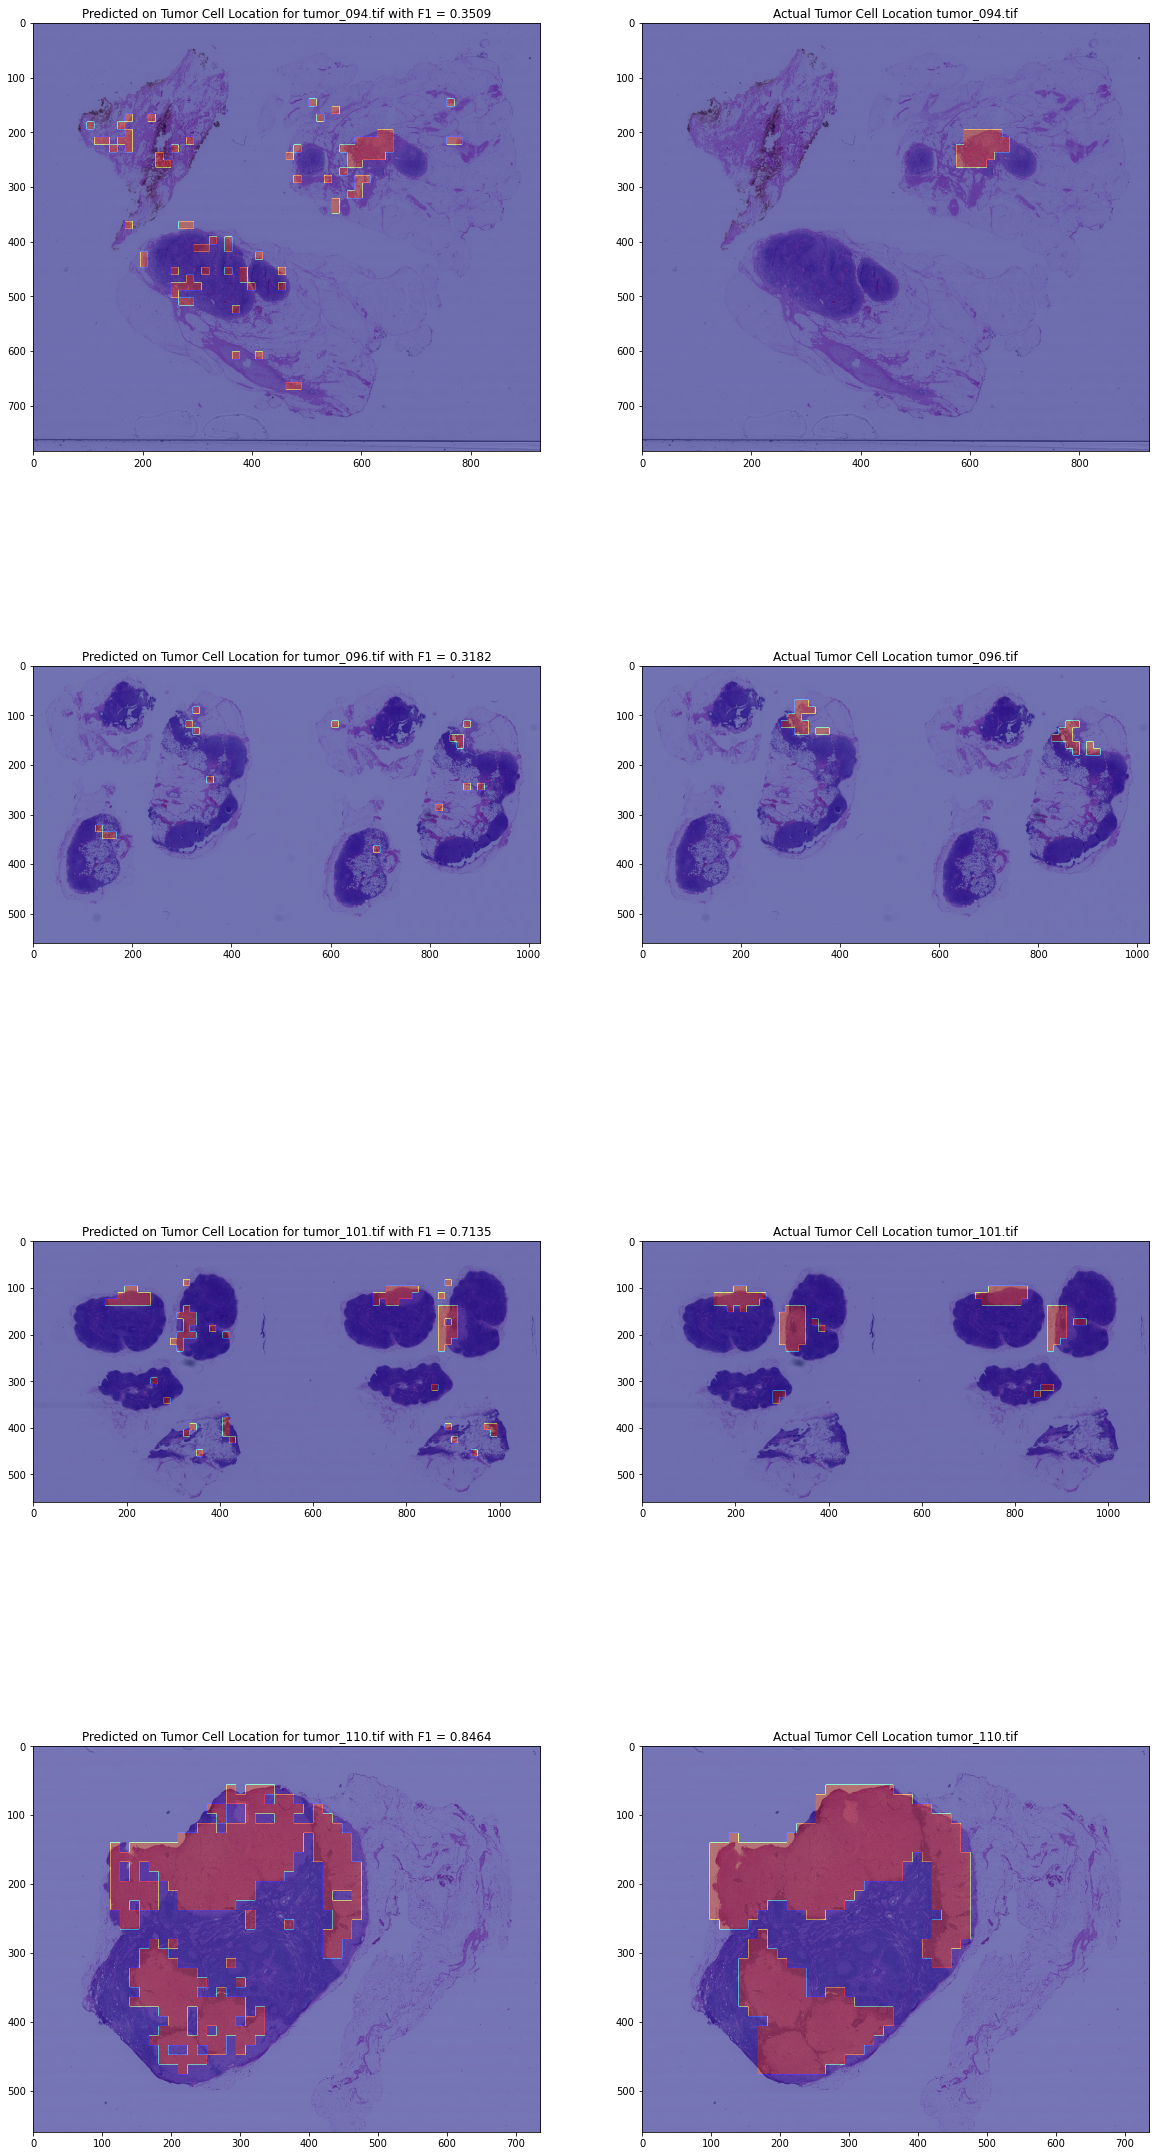

In [ ]:
all_outcomes_lv3, all_predictions_lv3, all_f1_lv3 = plot_test(model_lv3, 7, 3, test_outcomes)

### Level 4 Model

In [ ]:
model_lv4, history_lv4 = model_training(train_x_lv4[train_idx], train_x_lv4[val_idx], train_y[train_idx], train_y[val_idx])

Epoch 1/20
78/78 [==============================] - 110s 1s/step - loss: 0.5962 - accuracy: 0.7217 - val_loss: 4.3487 - val_accuracy: 0.0000e+00
Epoch 2/20
78/78 [==============================] - 103s 1s/step - loss: 1.3134 - accuracy: 0.4711 - val_loss: 2.7036 - val_accuracy: 0.0033
Epoch 3/20
78/78 [==============================] - 103s 1s/step - loss: 0.8064 - accuracy: 0.5016 - val_loss: 2.4957 - val_accuracy: 0.0362
Epoch 4/20
78/78 [==============================] - 102s 1s/step - loss: 0.6617 - accuracy: 0.5935 - val_loss: 2.4364 - val_accuracy: 0.0493
Epoch 5/20
78/78 [==============================] - 101s 1s/step - loss: 0.5627 - accuracy: 0.6580 - val_loss: 2.3877 - val_accuracy: 0.0691
Epoch 6/20
78/78 [==============================] - 100s 1s/step - loss: 0.5028 - accuracy: 0.6849 - val_loss: 2.4517 - val_accuracy: 0.0724
Epoch 7/20
78/78 [==============================] - 101s 1s/step - loss: 0.4651 - accuracy: 0.7235 - val_loss: 2.5080 - val_accuracy: 0.0625
Epoch 8/2

In [ ]:
model_lv4.save("/content/drive/My Drive/ADL_project/submodel_lv4.h5")

Overall f1:  0.3789


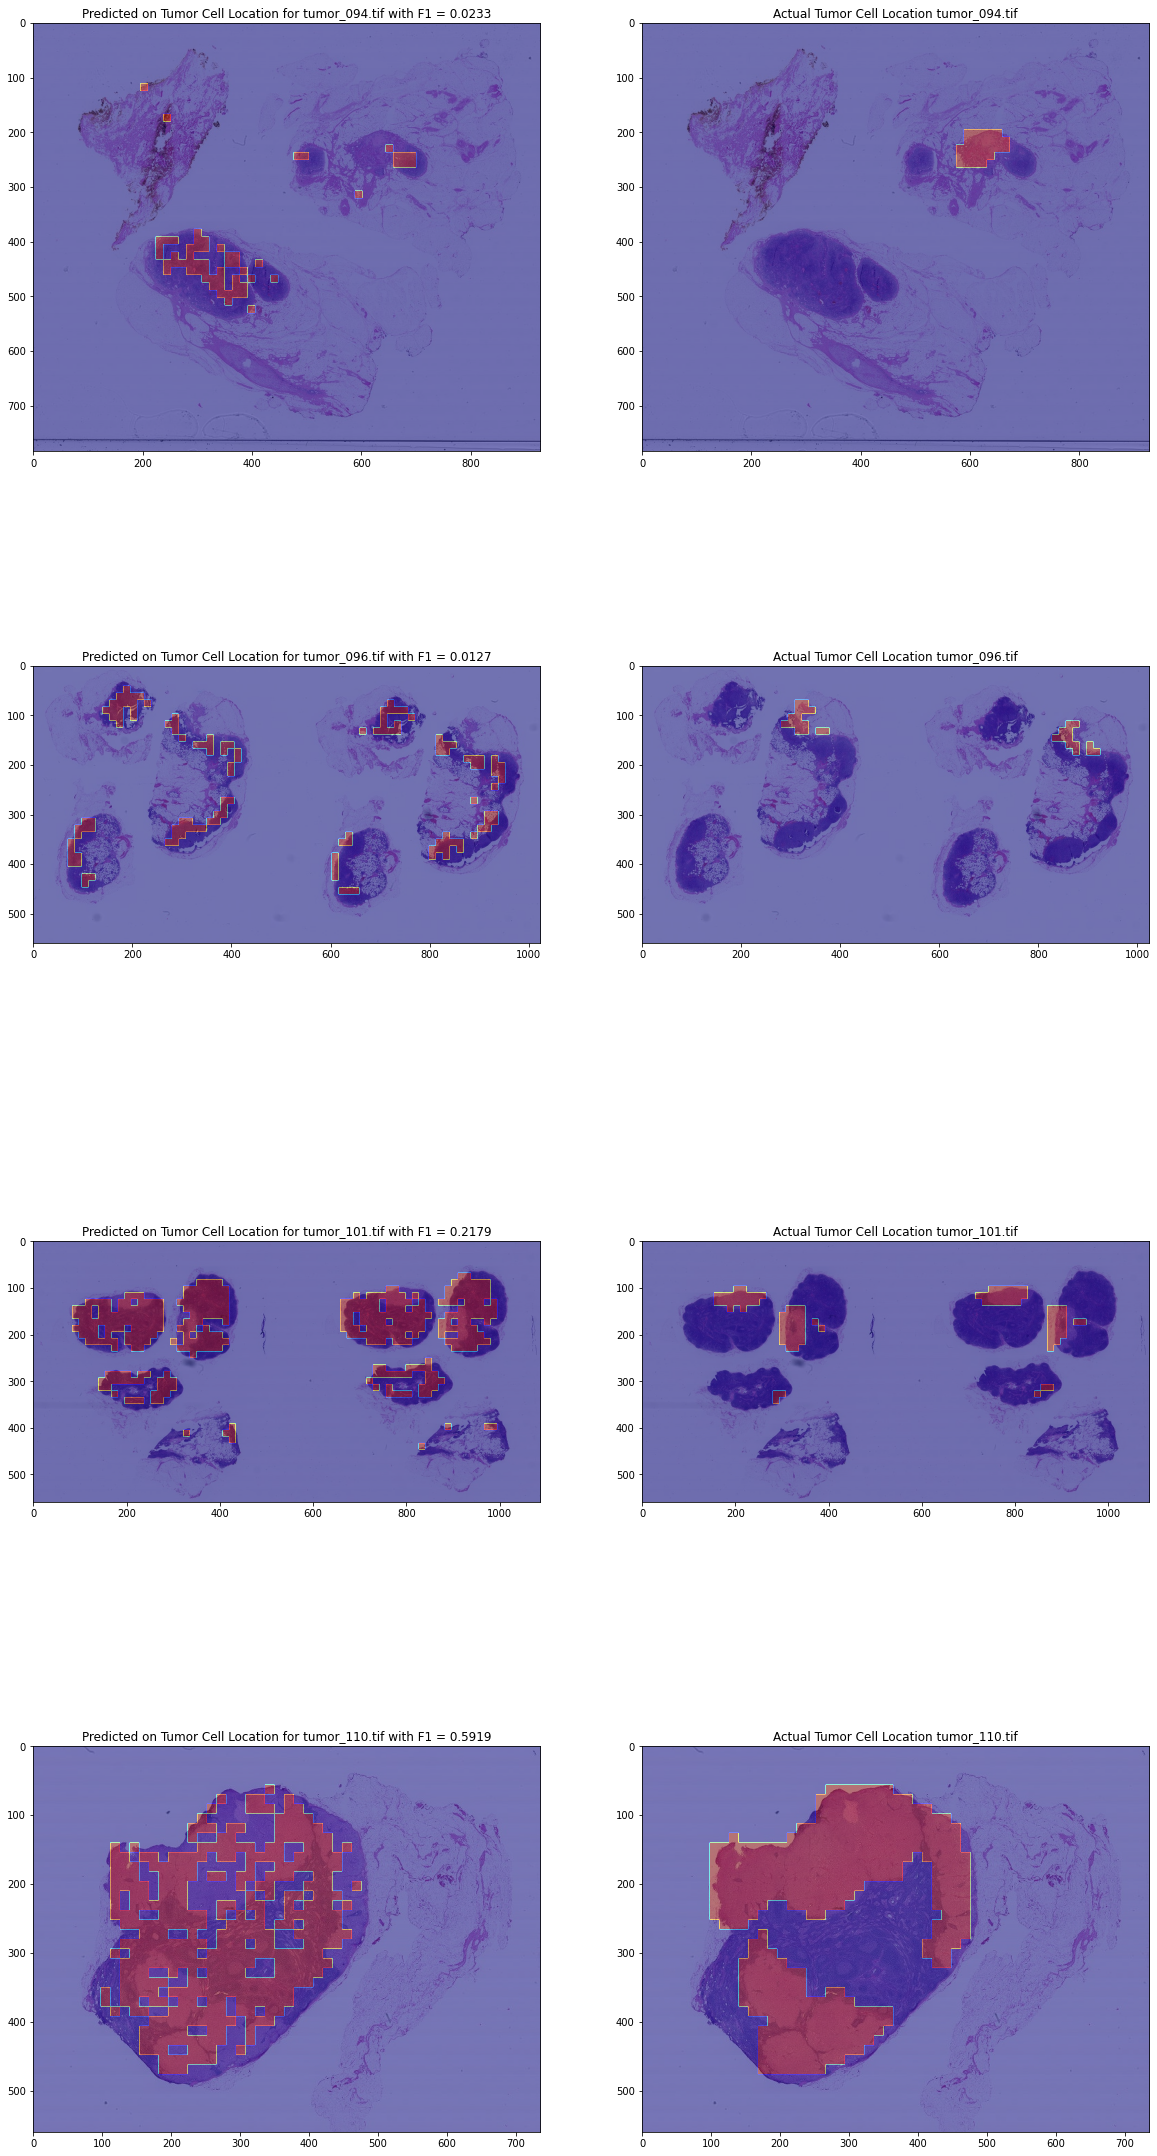

In [ ]:
all_outcomes_lv4, all_predictions_lv4, all_f1_lv4 = plot_test(model_lv4, 7, 3, test_outcomes)

### Level 5 Model

In [ ]:
model_lv5, history_lv5 = model_training(train_x_lv5[train_idx], train_x_lv5[val_idx], train_y[train_idx], train_y[val_idx])

Epoch 1/20
78/78 [==============================] - 105s 1s/step - loss: 0.4972 - accuracy: 0.8705 - val_loss: 4.9294 - val_accuracy: 0.0000e+00
Epoch 2/20
78/78 [==============================] - 100s 1s/step - loss: 1.5067 - accuracy: 0.4484 - val_loss: 2.8330 - val_accuracy: 0.0000e+00
Epoch 3/20
78/78 [==============================] - 102s 1s/step - loss: 1.0145 - accuracy: 0.4083 - val_loss: 2.3479 - val_accuracy: 0.0000e+00
Epoch 4/20
78/78 [==============================] - 101s 1s/step - loss: 0.7269 - accuracy: 0.4814 - val_loss: 2.4071 - val_accuracy: 0.0000e+00
Epoch 5/20
78/78 [==============================] - 101s 1s/step - loss: 0.6306 - accuracy: 0.5791 - val_loss: 2.3221 - val_accuracy: 0.0197
Epoch 6/20
78/78 [==============================] - 100s 1s/step - loss: 0.5126 - accuracy: 0.6840 - val_loss: 2.5055 - val_accuracy: 0.0329
Epoch 7/20
78/78 [==============================] - 100s 1s/step - loss: 0.4313 - accuracy: 0.7408 - val_loss: 2.4708 - val_accuracy: 0.06

In [ ]:
model_lv5.save("/content/drive/My Drive/ADL_project/submodel_lv5.h5")

Overall f1:  0.1453


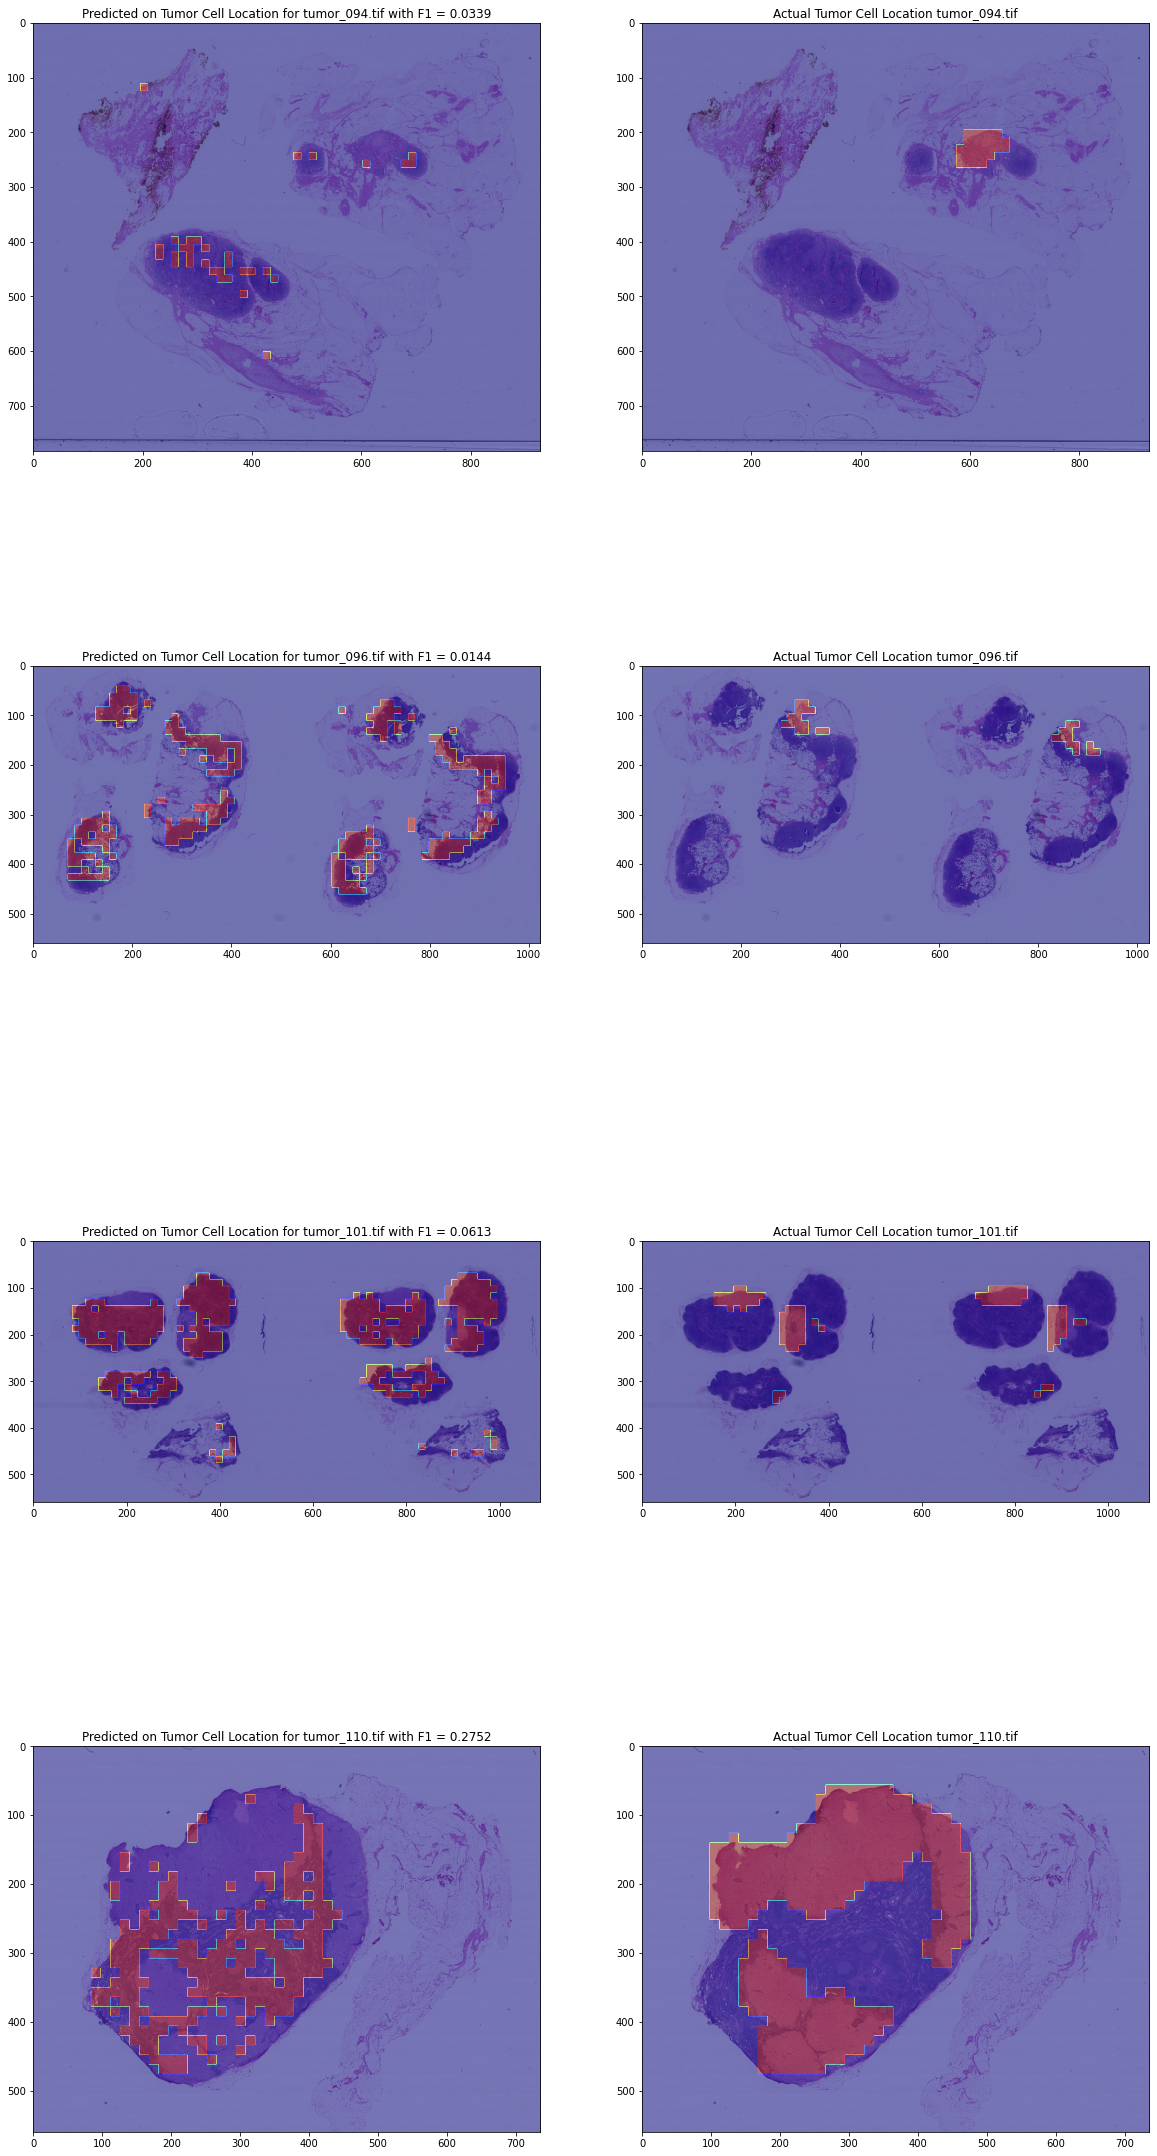

In [ ]:
all_outcomes_lv5, all_predictions_lv5, all_f1_lv5 = plot_test(model_lv5, 7, 3, test_outcomes)

Level 3 Model gives the best F1 score for the test set.

## Ensembel Mult Level


In [ ]:
#load data
model_lv3 = tf.keras.models.load_model("/content/drive/My Drive/ADL_project/submodel_lv3.h5")
model_lv4 =tf.keras.models.load_model("/content/drive/My Drive/ADL_project/submodel_lv4.h5")
model_lv5 =tf.keras.models.load_model("/content/drive/My Drive/ADL_project/submodel_lv5.h5")

train_idx = load_data("/content/drive/My Drive/ADL_project/train_idx.p")
val_idx = load_data("/content/drive/My Drive/ADL_project/val_idx.p")

In [ ]:
#from sklearn.datasets import make_blobs
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate


In [ ]:
# define stacked model from multiple member input models
# reference code: Jason Brownlee PhD https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/
def define_stacked_model(members):
  # update all layers in all models to not be trainable
  for i in range(len(members)):
    model = members[i]
    for layer in model.layers:
      # make not trainable
      layer.trainable = False
      # rename to avoid 'unique layer name' issue
      if not layer.name.startswith('ensemble'):
        layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
  # define multi-headed input
  ensemble_visible = [model.input for model in members]
  # concatenate merge output from each model
  ensemble_outputs = [model.output for model in members]
  merge = concatenate(ensemble_outputs)
  hidden = Dense(10, activation='relu')(merge)
  output = Dense(1)(hidden)
  model = Model(inputs=ensemble_visible, outputs=output)
  # plot graph of ensemble
  plot_model(model, show_shapes=True, to_file='model_graph.png')
  # compile
  base_learning_rate = 0.0001
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

In [ ]:
# make all three lv models into the members list and build the stacked models
members= [model_lv3, model_lv4, model_lv5]
stacked_model = define_stacked_model(members)

In [ ]:
#get all input data for stacked model
x1_train = train_x_lv3[train_idx]/255.0
x2_train = train_x_lv4[train_idx]/255.0
x3_train = train_x_lv5[train_idx]/255.0
labels = train_y[train_idx]

x1_val = train_x_lv3[val_idx]/255.0
x2_val = train_x_lv4[val_idx]/255.0
x3_val = train_x_lv5[val_idx]/255.0
val_labels = train_y[val_idx]


BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

dataset = tf.data.Dataset.from_tensor_slices(({stacked_model.input_names[0]: x1_train, stacked_model.input_names[1]: x2_train,stacked_model.input_names[2]: x3_train}, labels))
dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices(({stacked_model.input_names[0]: x1_val, stacked_model.input_names[1]: x2_val,stacked_model.input_names[2]: x3_val}, val_labels))
val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

#Configure the dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
dataset = dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
stacked_history = stacked_model.fit(dataset, epochs= 10, validation_data=val_dataset)

Epoch 1/10
39/39 [==============================] - 241s 6s/step - loss: 0.7599 - accuracy: 0.6085 - val_loss: 0.7189 - val_accuracy: 0.3553
Epoch 2/10
39/39 [==============================] - 231s 6s/step - loss: 0.7188 - accuracy: 0.6010 - val_loss: 0.7339 - val_accuracy: 0.3454
Epoch 3/10
39/39 [==============================] - 225s 6s/step - loss: 0.6731 - accuracy: 0.6437 - val_loss: 0.7480 - val_accuracy: 0.3289
Epoch 4/10
39/39 [==============================] - 224s 6s/step - loss: 0.6090 - accuracy: 0.6541 - val_loss: 0.7616 - val_accuracy: 0.3289
Epoch 5/10
39/39 [==============================] - 232s 6s/step - loss: 0.5678 - accuracy: 0.6646 - val_loss: 0.7748 - val_accuracy: 0.3092
Epoch 6/10
39/39 [==============================] - 229s 6s/step - loss: 0.5520 - accuracy: 0.6839 - val_loss: 0.7878 - val_accuracy: 0.3059
Epoch 7/10
39/39 [==============================] - 224s 6s/step - loss: 0.5164 - accuracy: 0.6983 - val_loss: 0.8004 - val_accuracy: 0.2993
Epoch 8/10
39

In [ ]:
stacked_model.save("/content/drive/My Drive/ADL_project/stacked_model_3.h5")

In [ ]:
stacked_model =tf.keras.models.load_model("/content/drive/My Drive/ADL_project/stacked_model_3.h5")

In [ ]:
# plot the heatmap for all 4 test tumor pictures at given plot level and their f1 scores
def plot_test_stack(model, plot_level, anc_level, test_outcomes):
  all_predictions =[]
  all_outcomes = []

  n_pics = len(slides_kps)
  train_len = int(round(n_pics * 0.8,0))
  test_size = n_pics - train_len
  batch_size = 50
  fig, axes = plt.subplots(nrows = test_size, ncols=2, figsize=(20, test_size*10))
  for i in range(test_size):
    slide_path = slides_kps[train_len+i]
    pic_len = len(test_patches[i])
    batches = int (pic_len / batch_size ) + 1
    predictions_pic = []
    for b in range(batches):
      s =  b * batch_size
      e = min(pic_len , s + batch_size)
      test_input = []
      test_input.append(test_patches[i][s:e]/255.0)
      test_input.append(np.array(test_mult[i][0][s:e])/255.0)
      test_input.append(np.array(test_mult[i][1][s:e])/255.0)
      predictions = model.predict(test_input).flatten()
      predictions = tf.nn.sigmoid(predictions)
      predictions = tf.where(predictions < 0.5, 0, 1)
      predictions_pic = np.concatenate((predictions_pic, predictions))

    all_predictions = np.concatenate((all_predictions, predictions_pic))
    all_outcomes = np.concatenate((all_outcomes, test_outcomes[i]))
    f1 = f1_score(test_outcomes[i], predictions_pic)
    #print(slide_path, '{:0.4f}'.format(roc))
    slide_image, mask_image, mask_image_true = get_mask(anc_level, plot_level, slide_path , predictions_pic, test_outcomes[i])
    axes[i][0].imshow(slide_image)
    axes[i][0].imshow(mask_image, cmap='jet', alpha=0.5)
    axes[i][0].set_title("Predicted on Tumor Cell Location for " + slide_path+ " with F1 = {:0.4f}".format(f1))
    axes[i][1].imshow(slide_image)
    axes[i][1].imshow(mask_image_true, cmap='jet', alpha=0.5)
    axes[i][1].set_title("Actual Tumor Cell Location " + slide_path);

  all_f1= f1_score(all_outcomes, all_predictions)
  print("Overall f1: ", '{:0.4f}'.format(all_f1))
  return (all_outcomes, all_predictions, all_f1)

Overall f1:  0.6109


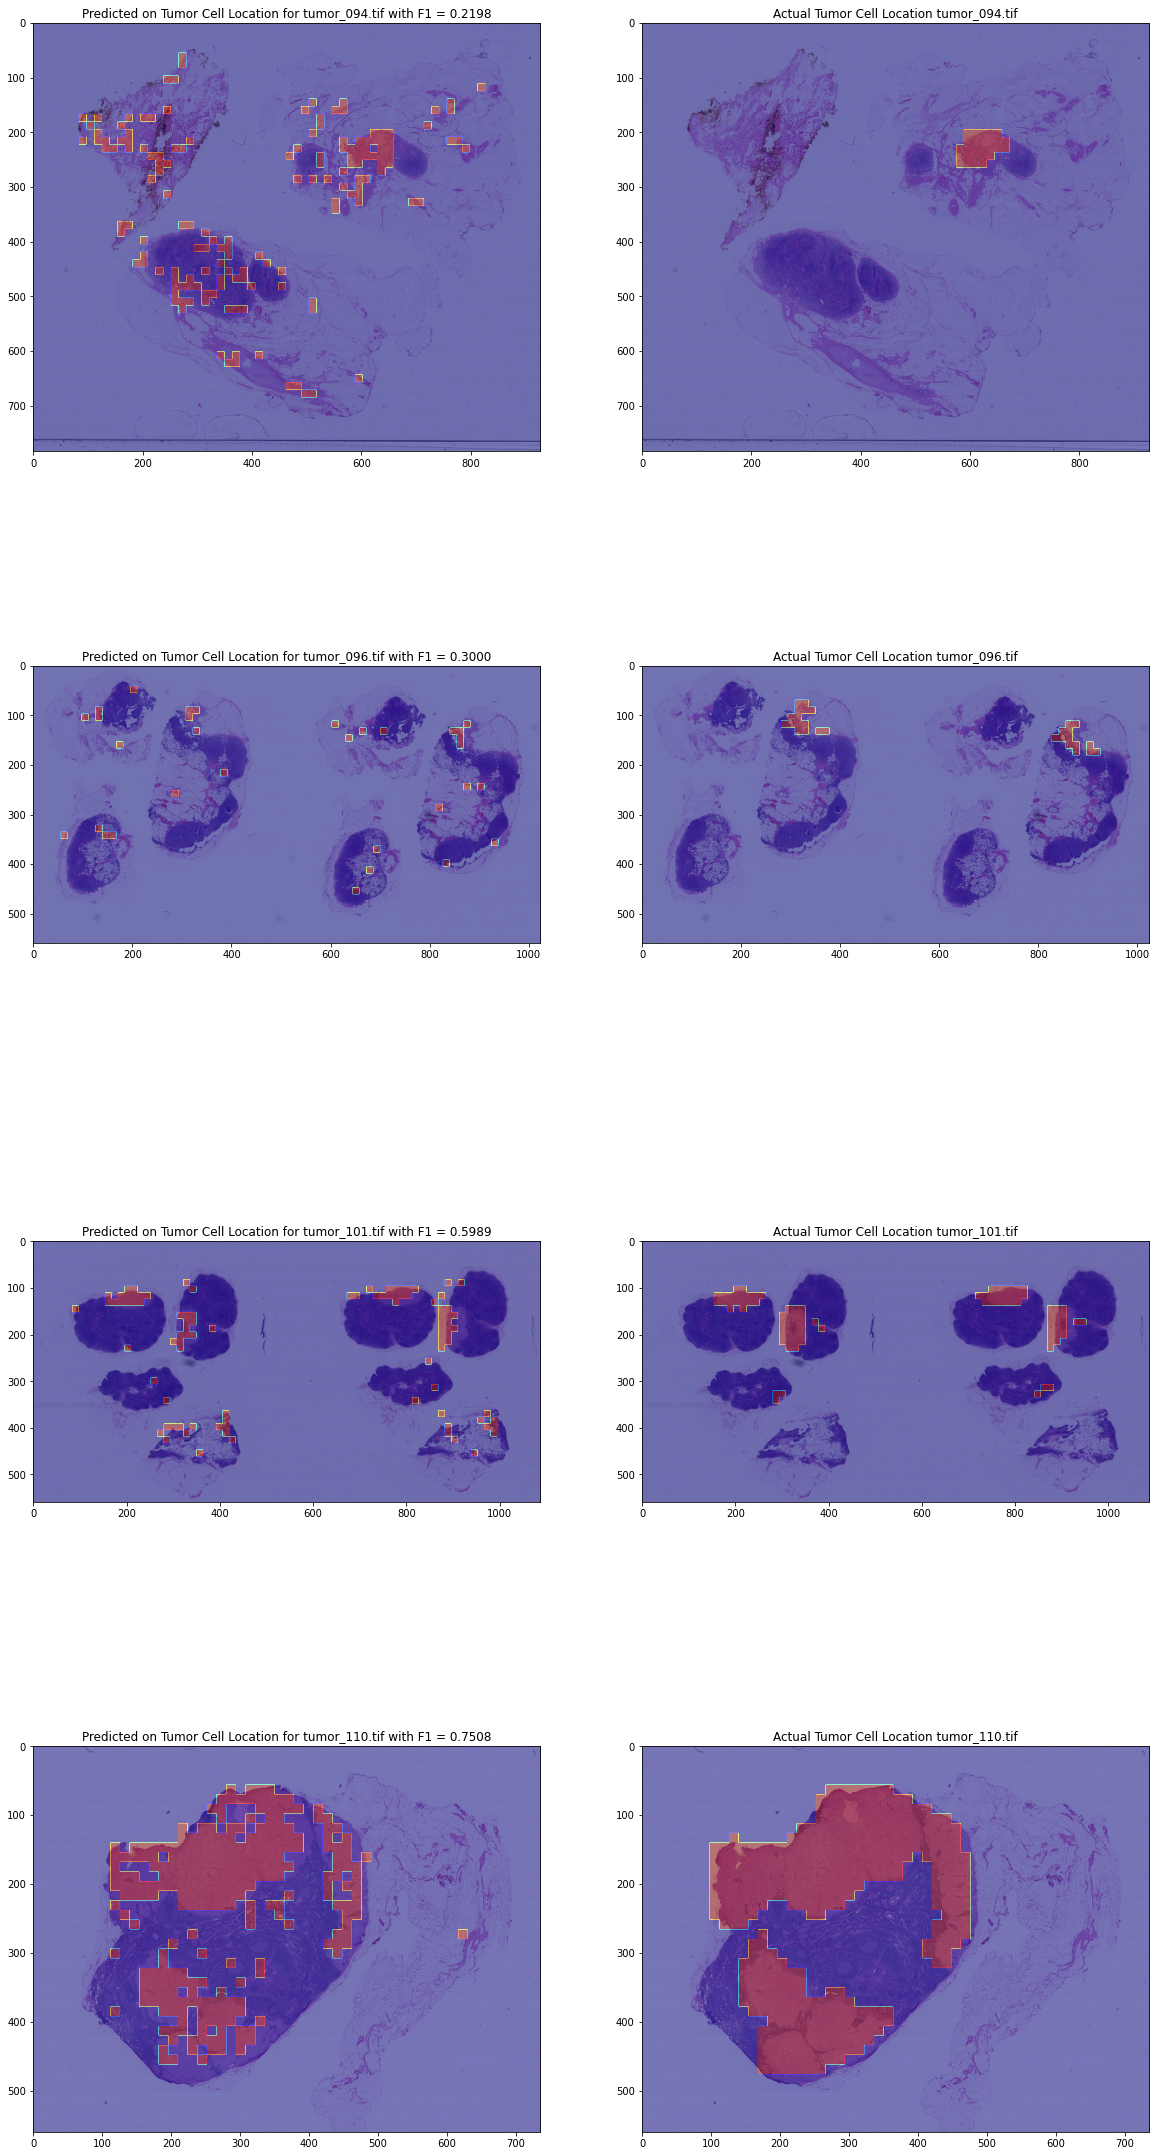

In [ ]:
all_outcomes_stacked, all_predictions_stacked, all_f1_stacked = plot_test_stack(stacked_model, 7, 3, test_outcomes)